<a href="https://colab.research.google.com/github/aulphin/GuISE-XAI/blob/main/GT_metric_GuISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/.shortcut-targets-by-id/1ho2ZxmQ9ohP8W6JjYS1G-B3VSrKWEEgi/New-Project


In [ ]:
!pip install scikit-image scikit-fuzzy

In [ ]:
############libraries #############
from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation
import numpy as np
from PIL import Image

Guided Mask

In [ ]:
#original_image = Image.open('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000158.jpg')

In [ ]:
original_image = Image.open('/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_img.jpg')

In [ ]:
original_array = np.array(original_image)
reshaped_array = np.array(Image.fromarray(original_array).resize((224, 224)))

# Check the new shape
print("Original shape:", original_array.shape)
print("Reshaped shape:", reshaped_array.shape)

reshaped_image = Image.fromarray(reshaped_array)
reshaped_image.save("fixed_img.jpg")

Original shape: (300, 400, 3)
Reshaped shape: (224, 224, 3)


Important Segments of slicing

In [ ]:
# Load the original image
original_img = io.imread('fixed_img.jpg')

# Apply SLIC with an appropriate number of segments
#n_segments = original_img.shape[0] * original_img.shape[1] // 10
n_segments = original_img.shape[0] * original_img.shape[1] // 256
#n_segments = original_img.shape[0] // 10

segments_slice = slic(original_img, n_segments=n_segments, compactness=10, sigma=1, multichannel=True)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  warnings.warn(self.warning_msg.format(


In [ ]:
# Visualize the segmented image with color boundaries
segmented_img = mark_boundaries(original_img, segments_slice)

In [ ]:
#Count the number of pixels in the original image
total_pixels_original = original_img.size

# Count the number of pixels in the segmented image after slicing
total_pixels_sliced = segments_slice.size

print(f"Number of pixels in the original image: {total_pixels_original}")
print(f"Number of pixels in the segmented image after slicing: {total_pixels_sliced}")

Number of pixels in the original image: 150528
Number of pixels in the segmented image after slicing: 50176


Fuzzy C-means Clustering

In [ ]:
from skimage import io, color
from skimage.filters import rank
from skfuzzy.cluster import cmeans

In [ ]:
# Convert the image to grayscale
gray_image = color.rgb2gray(original_img)

# Flatten the image into a 1D array
data = gray_image.flatten()

# Reshape the data into a 2D array (rows x features)
data = data.reshape((-1, 1))

In [ ]:
# Specify the number of clusters for CMeans
num_clusters = 4

In [ ]:
fuzzy_centers, fuzzy_partition_matrix, _, _, _, _, _ = cmeans(data.T, num_clusters, m=2, error=0.005, maxiter=1000)

# Convert the fuzzy partition matrix to a crisp partition matrix
crisp_labels = np.argmax(fuzzy_partition_matrix, axis=0)


In [ ]:
# Reshape the labels to the shape of the original image
clustered_image = crisp_labels.reshape(gray_image.shape)

End of Fuzzy c-means

In [ ]:
unique_cmeans_clusters = np.unique(crisp_labels)
print("Unique clusters from Fuzzy c-Means:", unique_cmeans_clusters)


Unique clusters from Fuzzy c-Means: [0 1 2 3]


In [ ]:
#######Assigning clusters to each segment #########
import numpy as np
from scipy.stats import mode


# Get the unique segments
unique_segments = np.unique(segments_slice)
print(len(unique_segments))

segment_clusters = {}

# Iterate through each unique segment
for segment in unique_segments:
    # Find the coordinates of pixels belonging to this segment
    coords = np.argwhere(segments_slice == segment)

    # Get the cluster IDs for these pixels
    cluster_ids = [clustered_image[x[0], x[1]] for x in coords]

    mode_result = mode(cluster_ids)
    #print(mode_result)
    mode_clusters = mode_result.mode
    #print(mode_clusters)


    # Assign the mode cluster ID to the segment
    segment_clusters[segment] = mode_clusters

157


In [ ]:
# Find the number of unique clusters assigned to segments
unique_assigned_clusters = np.unique(list(segment_clusters.values()))
num_unique_clusters = len(unique_assigned_clusters)

print("Number of unique clusters assigned to segments:", num_unique_clusters)

Number of unique clusters assigned to segments: 4


In [ ]:
# Show the clustered image
# color each cluster to visualize it better
unique_labels = np.unique(crisp_labels)
print(unique_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
#print(colors)
clustered_image_colored = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.float32)
for label, color in zip(unique_labels, colors):
    clustered_image_colored[clustered_image == label] = color[:3]
#clustered_image_colored

[0 1 2 3]


In [ ]:
print(clustered_image_colored.shape)


(224, 224, 3)


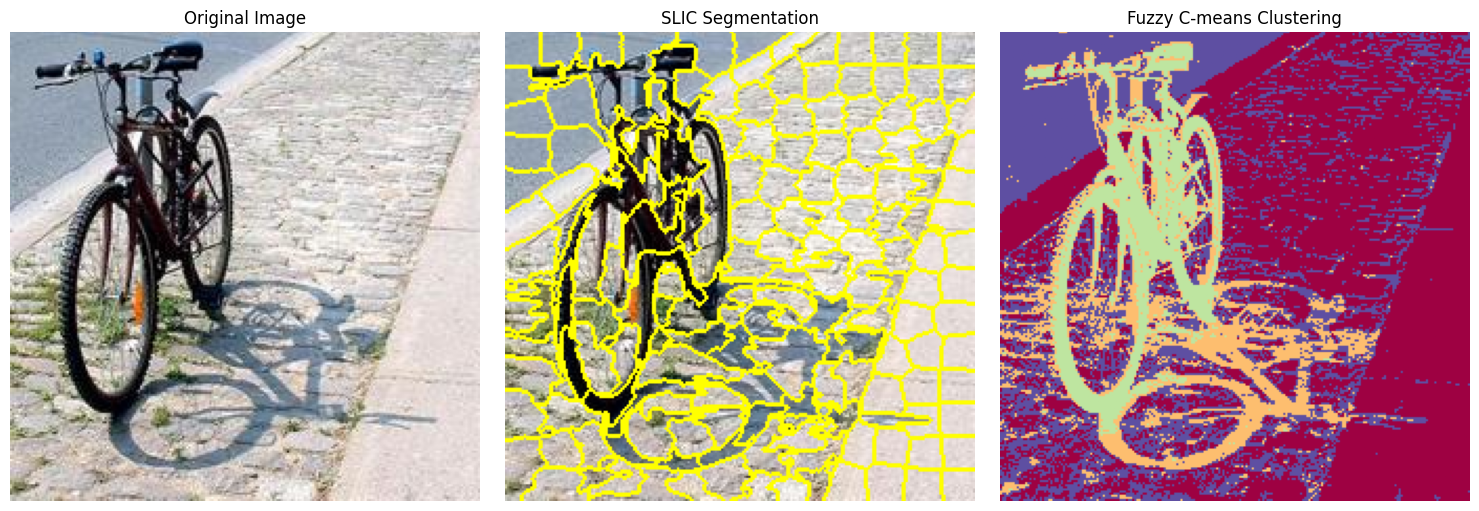

In [ ]:
# Let's plot the original image, the SLIC segmented image, and the K-means clustered image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Show SLIC segmented boundaries on the original image
axes[1].imshow(segmented_img)
axes[1].set_title('SLIC Segmentation')
axes[1].axis('off')

axes[2].imshow(clustered_image_colored, extent=(0, original_img.shape[1], original_img.shape[0], 0))
#axes[2].imshow(clustered_image_colored)
axes[2].set_title('Fuzzy C-means Clustering')
axes[2].axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3]


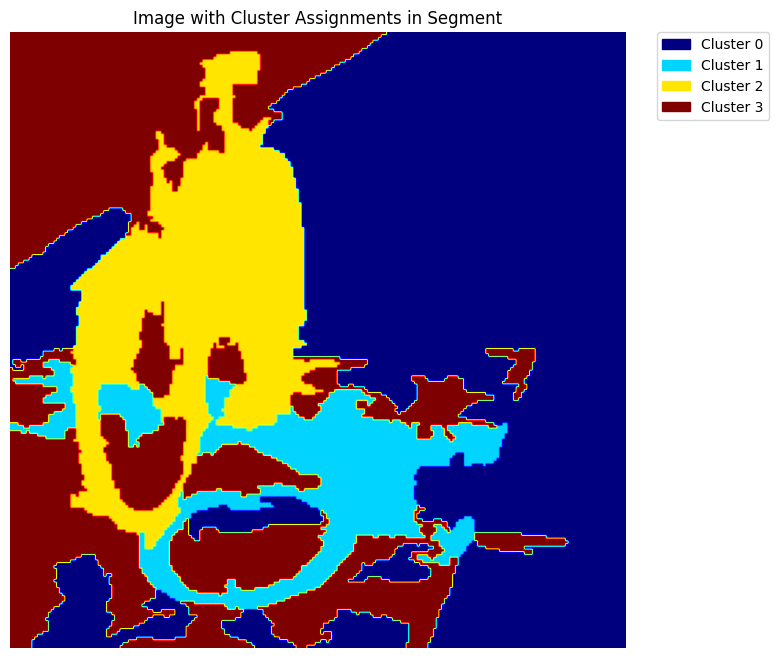

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode


# Create a color map
cmap = plt.cm.jet
norm = plt.Normalize(vmin=clustered_image.min(), vmax=clustered_image.max())

# Initialize a new image array
clustered_segments_img = np.zeros_like(segments_slice)

# Assign cluster colors to each segment
for segment, cluster in segment_clusters.items():
    clustered_segments_img[segments_slice == segment] = cluster



# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(clustered_segments_img, cmap=cmap)
plt.title("Image with Cluster Assignments in Segment")
plt.axis('off')  # Hide the axis

# Creating the legend
# Get unique clusters and their colors
unique_clusters = np.unique(clustered_segments_img)
print(unique_clusters)
colors = [cmap(norm(c)) for c in unique_clusters]

# Create a patch for each color
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {int(unique_clusters[i])}') for i in range(len(unique_clusters))]

# Add the legend to the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


In [ ]:
#clustered_segments_img
unique_values = np.unique(clustered_segments_img)
print(unique_values)


[0 1 2 3]


########### Histogram Implementation ##############

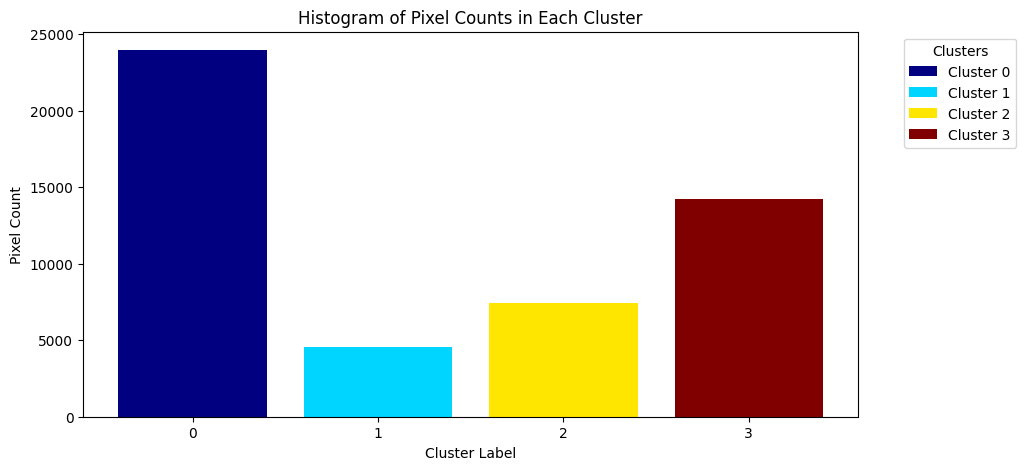

In [ ]:

k=4
# Count the pixels in each cluster
#cluster_pixel_counts = np.bincount(clustered_segments_img, minlength=k)

cluster_pixel_counts = np.bincount(clustered_segments_img.flatten(), minlength=k)
# Create the histogram with colored bars
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(range(0,k), cluster_pixel_counts, color=colors)

# Labeling the axes
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Pixel Count')
ax.set_title('Histogram of Pixel Counts in Each Cluster')
ax.set_xticks(range(0,k))
ax.set_xticklabels(range(0, k))

# Adding a legend to relate colors to clusters
plt.legend(bars, [f'Cluster {i}' for i in range(k)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the histogram
plt.show()


In [ ]:
# To compute the percentage of the image each cluster occupies here we have used the total number of pixels in the image
# and the number of pixels in each cluster.

# Total number of pixels in the image
total_pixels = original_img.shape[0] * original_img.shape[1]

# Calculate the percentage of each cluster
cluster_percentages = (cluster_pixel_counts / total_pixels) * 100

# Normalize the values to sum up to 100 and round to 2 decimal places
normalized_percentages = np.round((cluster_percentages / np.sum(cluster_percentages)) * 100, 2)

# Check if the sum is 100 after rounding, if not, adjust the last element to make the sum 100
if np.sum(normalized_percentages) != 100:
    difference = 100 - np.sum(normalized_percentages)
    normalized_percentages[-1] += difference

print(normalized_percentages)
#print(cluster_percentages)

[47.74  9.09 14.86 28.31]


In [ ]:
# #### New Computation ############3
# # normalized_percentages = np.array([26.32, 65.4, 34.99, 5.61, 11.61])
out =(normalized_percentages / 100)
#print(out)
prob = (1-out)
#print(prob)

#probabilities = np.round(prob, 2)
#print(prob)
probabilities = np.where(out > 0.2, 0.5, np.round(prob, 2))
print(probabilities)


[0.5  0.91 0.85 0.5 ]


In [ ]:
# ### Next New Computation #############
# a=np.max(normalized_percentages)
# b=0.5 #np.min(normalized_percentages)
# new_normalized_percentages=(normalized_percentages-b)/(a-b)

# prob=(1-new_normalized_percentages)
# probabilities=np.round(prob,2)
# print(probabilities)

In [ ]:
# cluster labels as keys and probabilities as values
cluster_probability_dict = {cluster_label: probability for cluster_label, probability in zip(range(0, k+1 ), probabilities)}

#Create the  formatted
cluster_probability = {"cluster " + str(cluster_label): probability for cluster_label, probability in cluster_probability_dict.items()}

# Print the result
print(cluster_probability)


{'cluster 0': 0.5, 'cluster 1': 0.91, 'cluster 2': 0.85, 'cluster 3': 0.5}


################## Rise method##########

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing import image
import random

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

In [ ]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)

    def run_on_batch(self, x):
        return self.model.predict(x)

In [ ]:
model = Model()

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
k=5
clusters = clustered_segments_img
# Define probabilities for each cluster
probabilities = cluster_probability
print(probabilities)
print(clusters.shape)

{'cluster 0': 0.5, 'cluster 1': 0.91, 'cluster 2': 0.85, 'cluster 3': 0.5}
(224, 224)


In [ ]:
########## Superpixel Experimenting ################
import numpy as np
from scipy.stats import mode

def generate_segment_masks(clusters, segments, probabilities):
    unique_segments = np.unique(segments)

    segment_clusters = {}

    # Assign clusters to each segment
    for segment in unique_segments:
        coords = np.argwhere(segments == segment)
        cluster_ids = [clusters[x[0], x[1]] for x in coords]

        mode_result = mode(cluster_ids)
        mode_clusters = mode_result.mode

        segment_clusters[segment] = mode_clusters

    # Initialize an empty mask
    mask = np.zeros_like(segments, dtype=float)
    #print(mask)
     # Count the number of segments for each cluster
    cluster_segment_counts = {}
    for segment, clusters in segment_clusters.items():
        if clusters.size > 0:
            cluster_id = int(clusters)
            if cluster_id in cluster_segment_counts:
                cluster_segment_counts[cluster_id] += 1
            else:
                cluster_segment_counts[cluster_id] = 1

    #print(cluster_segment_counts)
    for cluster_id, segment_count in cluster_segment_counts.items():
    # Get the probability for the current cluster
         cluster_key = f'cluster {cluster_id}'

         if cluster_key in probabilities:
                num_ones = int(probabilities[cluster_key] * segment_count)
                #print(num_ones)
                cluster_segments = [segment for segment, cluster in segment_clusters.items() if cluster == cluster_id]
                #print(cluster_segments)
                selected_segments = random.sample(cluster_segments, num_ones)
                #print(selected_segments)
                # Assign '1' to the selected segments in the mask
                for segment in selected_segments:
                     mask[segments == segment] = 1
    return mask



In [ ]:
result_masks = generate_segment_masks(clustered_image, segments_slice, probabilities)
# print(result_masks.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(result_masks)
# plt.colorbar()

In [ ]:
# No of mask
N= 512
masks = np.array([generate_segment_masks(clustered_image, segments_slice, probabilities) for _ in range(N)])
print(masks.shape)


(512, 224, 224)


In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_img.jpg'

In [ ]:
#image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000158.jpg'

In [ ]:
#image_path ='/content/drive/MyDrive/Colab Notebooks/New-Project/junco.jpg'
img, x = load_img(image_path)

In [ ]:
batch_size = 100

def explain(model, x, masks):
    preds = []

    masked = np.empty((N, *x.shape))

    for i in range(N):
              masked[i] = x* masks[i, :, :, np.newaxis]
              #plt.imshow(masked[3])
    masked

    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N
    return sal

In [ ]:
sal = explain(model,x, masks)

Explaining:   0%|          | 0/6 [00:00<?, ?it/s]

4/4 [==============================] - 1s 105ms/step


Explaining:  17%|█▋        | 1/6 [00:01<00:08,  1.70s/it]

4/4 [==============================] - 0s 79ms/step


Explaining:  33%|███▎      | 2/6 [00:02<00:04,  1.04s/it]

4/4 [==============================] - 0s 80ms/step


Explaining:  50%|█████     | 3/6 [00:02<00:02,  1.21it/s]

4/4 [==============================] - 0s 81ms/step


Explaining:  67%|██████▋   | 4/6 [00:03<00:01,  1.39it/s]

4/4 [==============================] - 0s 80ms/step


Explaining:  83%|████████▎ | 5/6 [00:04<00:00,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


Explaining: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


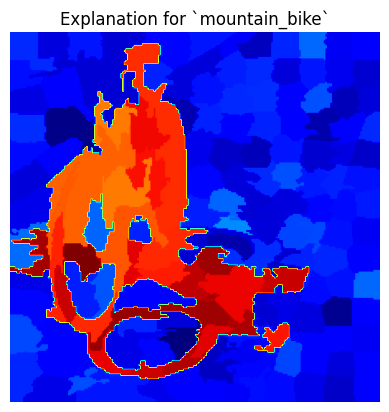

In [ ]:
class_idx = 671
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
saliency = sal[class_idx]
plt.imshow(saliency, cmap='jet')
# plt.colorbar()
plt.show()

In [ ]:
# Save the saliency map image
saliency_image_path = 'saliency_image.png'
plt.imsave(saliency_image_path, saliency, cmap='jet')

Experimenting Insertion and Deletion Score

In [ ]:
###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [ ]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [ ]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

# To use multiple GPUs
#model = nn.DataParallel(model)

Preparing Substrate Function

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

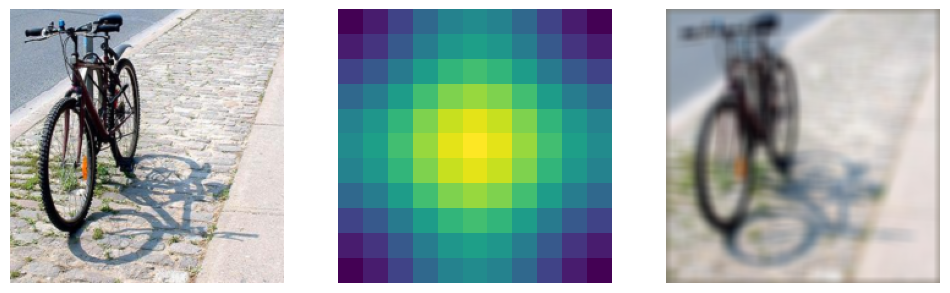

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_img.jpg')
#img= read_tensor('/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000158.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
######### Causal Metrics #######
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

########### Evaluating Metrics for Single Image #######


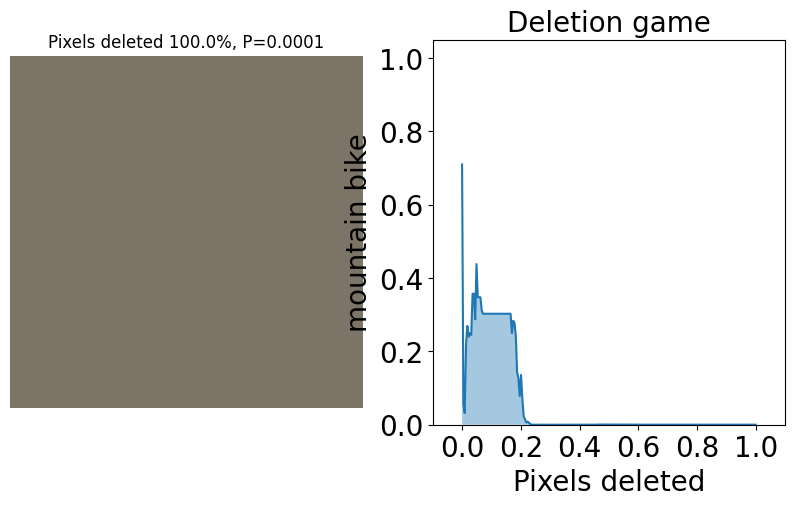

AUC: 0.05719529776237875


array([7.09869385e-01, 5.64045087e-02, 3.18973288e-02, 2.19061092e-01,
       2.69390732e-01, 2.40117699e-01, 2.49643296e-01, 2.44919971e-01,
       3.57277364e-01, 3.57277364e-01, 2.87355155e-01, 4.38217998e-01,
       3.47580612e-01, 3.47580612e-01, 3.47580612e-01, 3.11233491e-01,
       3.02636683e-01, 3.02636683e-01, 3.02636683e-01, 3.02636683e-01,
       3.02636683e-01, 3.02636683e-01, 3.02636683e-01, 3.02636683e-01,
       3.02636683e-01, 3.02636683e-01, 3.02636683e-01, 3.02636683e-01,
       3.02636683e-01, 3.02636683e-01, 3.02636683e-01, 3.02636683e-01,
       3.02636683e-01, 3.02636683e-01, 3.02636683e-01, 3.02636683e-01,
       3.02636683e-01, 3.02636683e-01, 2.49838904e-01, 2.83460408e-01,
       2.77513027e-01, 2.42721871e-01, 1.43044889e-01, 1.26315162e-01,
       7.80768692e-02, 1.35803014e-01, 7.04656094e-02, 2.35714391e-02,
       1.45725338e-02, 6.05775556e-03, 8.27848259e-03, 5.20751905e-03,
       2.14218651e-03, 7.51379048e-05, 4.53639004e-05, 3.31179290e-05,
      

In [ ]:
deletion.single_run(img, sal, verbose=1)

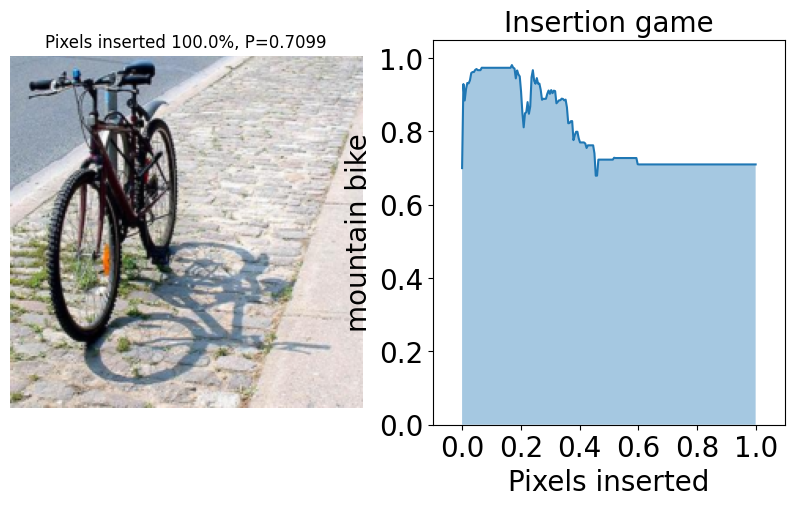

AUC: 0.7978555447022829


array([0.69989687, 0.92906278, 0.88426936, 0.9155435 , 0.93213755,
       0.93091929, 0.93925947, 0.95916647, 0.96188593, 0.96188593,
       0.96752965, 0.97008002, 0.96696711, 0.96696711, 0.96696711,
       0.97361088, 0.97344661, 0.97344661, 0.97344661, 0.97344661,
       0.97344661, 0.97344661, 0.97344661, 0.97344661, 0.97344661,
       0.97344661, 0.97344661, 0.97344661, 0.97344661, 0.97344661,
       0.97344661, 0.97344661, 0.97344661, 0.97344661, 0.97344661,
       0.97344661, 0.97344661, 0.97344661, 0.98083156, 0.97361338,
       0.9715575 , 0.94458032, 0.9662506 , 0.95537519, 0.94991314,
       0.90861261, 0.8511712 , 0.81107283, 0.84937215, 0.85235327,
       0.87987345, 0.84805739, 0.86774403, 0.94733971, 0.96694905,
       0.93796861, 0.92993653, 0.94537824, 0.93002224, 0.93034136,
       0.91319805, 0.88623941, 0.88896698, 0.88861358, 0.88907814,
       0.90238482, 0.91144282, 0.90249354, 0.91265982, 0.90424454,
       0.91111612, 0.9098376 , 0.87660521, 0.88070345, 0.88478

In [ ]:
insertion.single_run(img, sal, verbose=1)

Computing Ground Truth mask

In [ ]:
import cv2
import numpy as np

In [ ]:
gt_mask_path ='/content/drive/MyDrive/Colab Notebooks/New-Project/0_2_2546_gtm.png'
saliency_image_path = '/content/drive/MyDrive/Colab Notebooks/New-Project/saliency_image.png'

In [ ]:
import cv2
import numpy as np

def compute_mGT(gt_mask_path, saliency_image_path):

    # Load and resize to match the dimensions images
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    saliency_image = cv2.imread(saliency_image_path, cv2.IMREAD_GRAYSCALE)

    gt_mask_resized = cv2.resize(gt_mask, (saliency_image.shape[1], saliency_image.shape[0]))


    # Number of white pixels in GT mask computing as p
    p = np.sum(gt_mask_resized == 255)
    print(f"number of white pixels in ground truth mask: {p}")

    # Flatten the saliency mask pixels and sorting in decreasing order
    flat_saliency = saliency_image.flatten()
    print(flat_saliency)
    sorted_indices = np.argsort(flat_saliency)[::-1]

    # Select the indices of the top p pixels from the saliency map
    top_p_indices = sorted_indices[:p]
    print(top_p_indices)

    # Now create the binary mask for the saliency map
    saliency_mask = np.zeros_like(flat_saliency, dtype=np.uint8)
    saliency_mask[top_p_indices] = 1
    saliency_mask = saliency_mask.reshape(saliency_image.shape)

    c = np.sum(saliency_mask == 1)
    print(f"number of white pixels in saliency mask: {c}")

    # Create ground truth binary mask
    gt_binary_mask = np.where(gt_mask_resized == 255, 1, 0).astype(np.uint8)
    print(f"number of white pixels in ground truth binary mask: {np.sum(gt_binary_mask ==1)}")

    # Compute the number of overlapping positive pixels
    n = np.sum((gt_binary_mask == 1) & (saliency_mask == 1))

    # Compute the mGT metric
    mGT = n / p if p != 0 else 0  # To avoid division by zero

    return mGT


In [ ]:
# Compute mGT
mGT = compute_mGT(gt_mask_path, saliency_image_path)
print(f'mGT: {mGT}')

number of white pixels in ground truth mask: 8521
[52 52 52 ... 29 29 29]
[14610 12164 20216 ... 21366 21365 18668]
number of white pixels in saliency mask: 8521
number of white pixels in ground truth binary mask: 8521
mGT: 0.6636545006454642
